In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rwf2000/RWF-2000/val/Fight/JECBfnp2ZXc_2.avi
/kaggle/input/rwf2000/RWF-2000/val/Fight/RETYTDF_523.avi
/kaggle/input/rwf2000/RWF-2000/val/Fight/39BFeYnbu-I_7.avi
/kaggle/input/rwf2000/RWF-2000/val/Fight/1Kbw1bUw_0.avi
/kaggle/input/rwf2000/RWF-2000/val/Fight/48J5lk4QcpE_0.avi
/kaggle/input/rwf2000/RWF-2000/val/Fight/MxkTo5F-nvU_1.avi
/kaggle/input/rwf2000/RWF-2000/val/Fight/SDFDSSDF_977.avi
/kaggle/input/rwf2000/RWF-2000/val/Fight/RTHTRS_720.avi
/kaggle/input/rwf2000/RWF-2000/val/Fight/nuf-d5GugL0_5.avi
/kaggle/input/rwf2000/RWF-2000/val/Fight/RTHTRS_697.avi
/kaggle/input/rwf2000/RWF-2000/val/Fight/OvDMIkTb4XU_1.avi
/kaggle/input/rwf2000/RWF-2000/val/Fight/ASGGSDG_183.avi
/kaggle/input/rwf2000/RWF-2000/val/Fight/mwuiYEBdkJs_3.avi
/kaggle/input/rwf2000/RWF-2000/val/Fight/e5Dmmply_2.avi
/kaggle/input/rwf2000/RWF-2000/val/Fight/nuf-d5GugL0_6.avi
/kaggle/input/rwf2000/RWF-2000/val/Fight/I-QiUMPTWNE_3.avi
/kaggle/input/rwf2000/RWF-2000/val/Fight/FXC43fACfPc_1.avi
/kaggle/input/

In [7]:
import os
import cv2

dataset_path = "/kaggle/input/rwf2000/RWF-2000"

def get_video_duration(video_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return 0
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    duration = frame_count / fps if fps > 0 else 0
    cap.release()
    return duration

def process_dataset(dataset_path):
    folder_stats = {}
    total_videos = 0
    total_duration = 0

    for root, dirs, files in os.walk(dataset_path):
        video_count = 0
        folder_duration = 0
        for file in files:
            if file.endswith((".mp4", ".avi", ".mkv")): 
                video_count += 1
                video_path = os.path.join(root, file)
                folder_duration += get_video_duration(video_path)
        
        if video_count > 0:
            folder_name = os.path.basename(root)
            folder_stats[folder_name] = {
                "video_count": video_count,
                "duration": folder_duration
            }
            total_videos += video_count
            total_duration += folder_duration
            
            print(f"Processing Folder: {folder_name}")
            print(f"  Videos: {video_count}")
            print(f"  Duration: {folder_duration:.2f} seconds\n")

    return folder_stats, total_videos, total_duration

stats, total_videos, total_duration = process_dataset(dataset_path)

print("========== Dataset Summary ==========")
print(f"Total Videos: {total_videos}")
print(f"Total Duration: {total_duration:.2f} seconds")


Processing Folder: Fight
  Videos: 200
  Duration: 1000.00 seconds

Processing Folder: NonFight
  Videos: 200
  Duration: 1000.00 seconds

Processing Folder: Fight
  Videos: 800
  Duration: 4000.00 seconds

Processing Folder: NonFight
  Videos: 800
  Duration: 4000.00 seconds

========== Dataset Summary ==========
Total Videos: 2000
Total Duration: 10000.00 seconds


In [12]:

import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, 
    GRU, LSTM, TimeDistributed
)
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, classification_report
import shutil
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [9]:
IMG_SIZE = 64  
SEQ_LENGTH = 30  
DATASET_PATH = "/kaggle/input/rwf2000/RWF-2000"
OUTPUT_PATH = "/kaggle/working/processed_data"

fight_output_path = os.path.join(OUTPUT_PATH, "fight")
nonfight_output_path = os.path.join(OUTPUT_PATH, "nonfight")
os.makedirs(fight_output_path, exist_ok=True)
os.makedirs(nonfight_output_path, exist_ok=True)

def preprocess_videos(source_path, label):
    for video_name in os.listdir(source_path):
        video_path = os.path.join(source_path, video_name)
        cap = cv2.VideoCapture(video_path)

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  
        fps = cap.get(cv2.CAP_PROP_FPS) 
        duration = total_frames / fps if fps > 0 else 0 

        if duration <= 0:
            cap.release()
            continue  

        
        frame_interval = max(1, total_frames // SEQ_LENGTH)  

        frames = []
        for i in range(SEQ_LENGTH):
            frame_index = min(i * frame_interval, total_frames - 1)  
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)  
            frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
            frame = frame / 255.0  
            frame = frame.flatten()  # Convert to 1D vector of shape (4096,)
            frames.append(frame)

        cap.release()

        while len(frames) < SEQ_LENGTH:
            frames.append(frames[-1])  

        frames_array = np.array(frames)  # Final shape: (30, 4096)
        save_path = fight_output_path if label == "fight" else nonfight_output_path
        np.save(os.path.join(save_path, f"{video_name}.npy"), frames_array)

# Process fight and nonfight videos
print("Processing Fight Videos...")
preprocess_videos(os.path.join(DATASET_PATH, "train", "Fight"), "fight")
preprocess_videos(os.path.join(DATASET_PATH, "val", "Fight"), "fight")

print("Processing Non-Fight Videos...")
preprocess_videos(os.path.join(DATASET_PATH, "train", "NonFight"), "nonfight")
preprocess_videos(os.path.join(DATASET_PATH, "val", "NonFight"), "nonfight")

print("Processing Completed! Frames are stored.")


Processing Fight Videos...
Processing Non-Fight Videos...
Processing Completed! Frames are stored.


In [10]:

def split_data(source_folder, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2):
    files = [f for f in os.listdir(source_folder) if f.endswith('.npy')]
    train_files, temp_files = train_test_split(files, test_size=(val_ratio + test_ratio))
    val_files, test_files = train_test_split(temp_files, test_size=test_ratio / (val_ratio + test_ratio))
    
    return train_files, val_files, test_files

splits = ["train", "val", "test"]
for split in splits:
    for category in ["fight", "nonfight"]:
        os.makedirs(os.path.join(OUTPUT_PATH, split, category), exist_ok=True)

def move_files(file_list, src_folder, dest_folder):
    for file in file_list:
        shutil.move(os.path.join(src_folder, file), os.path.join(dest_folder, file))

print("Splitting Data...")

train_f, val_f, test_f = split_data(fight_output_path)
move_files(train_f, fight_output_path, os.path.join(OUTPUT_PATH, "train", "fight"))
move_files(val_f, fight_output_path, os.path.join(OUTPUT_PATH, "val", "fight"))
move_files(test_f, fight_output_path, os.path.join(OUTPUT_PATH, "test", "fight"))

train_nf, val_nf, test_nf = split_data(nonfight_output_path)
move_files(train_nf, nonfight_output_path, os.path.join(OUTPUT_PATH, "train", "nonfight"))
move_files(val_nf, nonfight_output_path, os.path.join(OUTPUT_PATH, "val", "nonfight"))
move_files(test_nf, nonfight_output_path, os.path.join(OUTPUT_PATH, "test", "nonfight"))

print("Data Splitting Complete! Train, Val, and Test sets are ready.")


Splitting Data...
Data Splitting Complete! Train, Val, and Test sets are ready.


In [11]:

DATA_PATH = "/kaggle/working/processed_data"
splits = ["train", "val", "test"]
categories = ["fight", "nonfight"]

def load_data(split):
    X, y = [], []
    for label, category in enumerate(categories):
        folder_path = os.path.join(DATA_PATH, split, category)
        for file in os.listdir(folder_path):
            data = np.load(os.path.join(folder_path, file))  # Shape: (30, IMG_SIZE, IMG_SIZE, 3)
            data = data.reshape(30, -1)  # Flatten image features per frame (30, 4096)
            X.append(data)
            y.append(label)
    
    return np.array(X), np.array(y)

# Load datasets
X_train, y_train = load_data("train")
X_val, y_val = load_data("val")
X_test, y_test = load_data("test")

# Convert labels to categorical (one-hot encoding)
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

print(f"Train Shape: {X_train.shape}, Validation Shape: {X_val.shape}, Test Shape: {X_test.shape}")


Train Shape: (1200, 30, 4096), Validation Shape: (400, 30, 4096), Test Shape: (400, 30, 4096)


In [13]:

cnn_model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(30, 4096)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history_cnn = cnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

cnn_model.save("/kaggle/working/1dcnn_model.h5")

cnn_feature_extractor = Sequential(cnn_model.layers[:-2]) 
X_train_features = cnn_feature_extractor.predict(X_train)
X_val_features = cnn_feature_extractor.predict(X_val)
X_test_features = cnn_feature_extractor.predict(X_test)

print(f"Feature Extracted Shape: {X_train_features.shape}")  

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 162ms/step - accuracy: 0.5845 - loss: 1.1148 - val_accuracy: 0.5500 - val_loss: 0.9331
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5700 - loss: 1.0889 - val_accuracy: 0.5125 - val_loss: 1.7186
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6243 - loss: 0.8865 - val_accuracy: 0.6025 - val_loss: 0.7398
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6393 - loss: 0.8424 - val_accuracy: 0.5175 - val_loss: 0.8355
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7180 - loss: 0.6552 - val_accuracy: 0.6425 - val_loss: 0.9063
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7263 - loss: 0.5661 - val_accuracy: 0.6500 - val_loss: 0.6653
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7542 - loss: 0.5551 - val_accuracy: 0.6650 - val_loss: 0.6813
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7895 - loss: 0.4745 - val_accuracy: 0.5300 -

In [14]:

X_train_gru = X_train_features.reshape(X_train_features.shape[0], X_train_features.shape[1], 1)
X_val_gru = X_val_features.reshape(X_val_features.shape[0], X_val_features.shape[1], 1)
X_test_gru = X_test_features.reshape(X_test_features.shape[0], X_test_features.shape[1], 1)


gru_model = Sequential([
    GRU(128, return_sequences=True, input_shape=(X_train_gru.shape[1], 1)),
    GRU(64),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

history_gru = gru_model.fit(X_train_gru, y_train, validation_data=(X_val_gru, y_val), epochs=20, batch_size=32)

gru_model.save("/kaggle/working/gru_model.h5")


Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.6432 - loss: 0.6098 - val_accuracy: 0.6575 - val_loss: 0.7328
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8049 - loss: 0.4010 - val_accuracy: 0.6825 - val_loss: 0.8327
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8616 - loss: 0.3524 - val_accuracy: 0.6700 - val_loss: 0.7652
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8667 - loss: 0.3190 - val_accuracy: 0.6750 - val_loss: 0.9254
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8733 - loss: 0.3012 - val_accuracy: 0.7075 - val_loss: 1.0056
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8926 - loss: 0.2577 - val_accuracy: 0.6975 - val_loss: 0.8217
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8884 - loss: 0.2588 - val_accuracy: 0.6975 - val_loss: 0.9920
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8839 - loss: 0.2734 - val_accuracy: 0.6850 - v

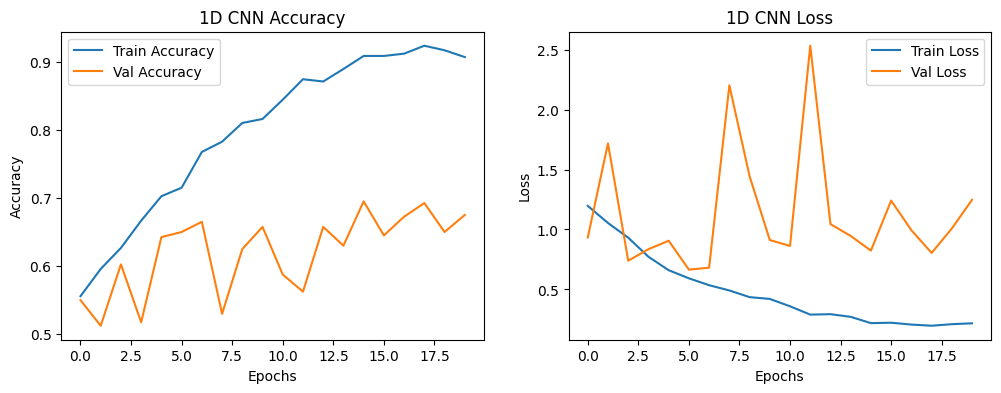

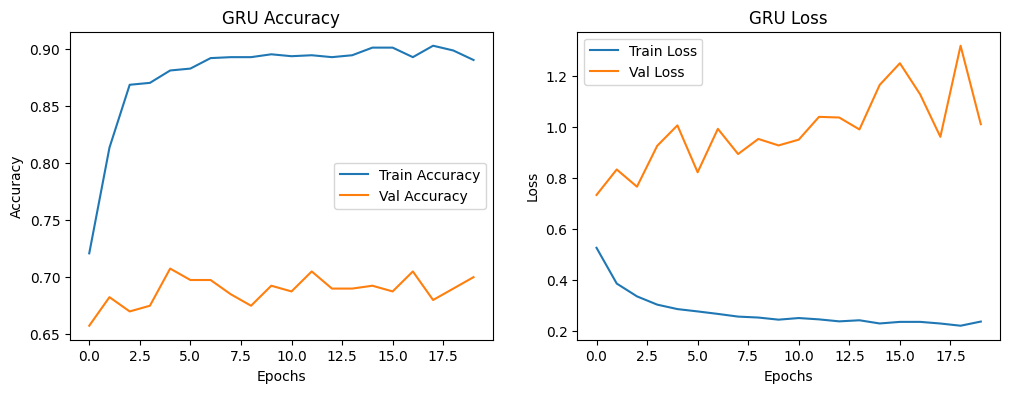

In [15]:
def plot_results(history, model_name):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f"{model_name} Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"{model_name} Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

plot_results(history_cnn, "1D CNN")

plot_results(history_gru, "GRU")


In [16]:
cnn_test_loss, cnn_test_acc = cnn_model.evaluate(X_test, y_test)
gru_test_loss, gru_test_acc = gru_model.evaluate(X_test_gru, y_test)

print(f"1D CNN Test Accuracy: {cnn_test_acc * 100:.2f}%")
print(f"GRU Test Accuracy: {gru_test_acc * 100:.2f}%")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7128 - loss: 0.9996
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7277 - loss: 0.7961
1D CNN Test Accuracy: 68.50%
GRU Test Accuracy: 69.25%


In [32]:

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

print(f"Updated Labels Shape: {y_train.shape}")

Updated Labels Shape: (1200, 2)


In [39]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, BatchNormalization, Dense, Dropout, GRU, 
    Bidirectional, Input, TimeDistributed, Flatten, LayerNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

input_shape = (30, 4096)  
input_layer = Input(shape=input_shape)

x = Conv1D(128, kernel_size=5, activation='relu', padding='same', kernel_regularizer=l2(0.001))(input_layer)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(256, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

x = Conv1D(512, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=2)(x)

x = TimeDistributed(Dense(128, activation='relu'))(x)  
x = Dropout(0.4)(x)  # Added dropout here

x = Bidirectional(GRU(512, return_sequences=True, recurrent_dropout=0.3))(x)
x = Bidirectional(GRU(256, return_sequences=True, recurrent_dropout=0.3))(x)
x = Bidirectional(GRU(128, recurrent_dropout=0.3))(x)

x = LayerNormalization()(x)  

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
output_layer = Dense(2, activation='softmax')(x)

hybrid_model = Model(inputs=input_layer, outputs=output_layer)

optimizer = Adam(learning_rate=0.0005)
hybrid_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)

history_hybrid = hybrid_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50, 
    batch_size=32,
    callbacks=[lr_scheduler, early_stopping]
)

hybrid_model.save("/kaggle/working/hybrid_model.h5")

test_loss, test_acc = hybrid_model.evaluate(X_test, y_test)
print(f"🔹 Hybrid Model Test Accuracy: {test_acc * 100:.2f}%")


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 124ms/step - accuracy: 0.5846 - loss: 1.8453 - val_accuracy: 0.5000 - val_loss: 1.7487 - learning_rate: 5.0000e-04
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.6108 - loss: 1.5891 - val_accuracy: 0.6125 - val_loss: 1.5871 - learning_rate: 5.0000e-04
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.6479 - loss: 1.5371 - val_accuracy: 0.6375 - val_loss: 1.5092 - learning_rate: 5.0000e-04
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.6445 - loss: 1.4978 - val_accuracy: 0.6150 - val_loss: 1.5457 - learning_rate: 5.0000e-04
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.7310 - loss: 1.3988 - val_accuracy: 0.6300 - val_loss: 1.4765 - learning_rate: 5.0000e-04
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.7461 - loss: 1.3501 - val_accuracy: 0.5775 - val_loss: 1.5607 - learning_rate: 5.0000e-04
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.717

In [42]:
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

# Ensure labels start from 0
y_train_xgb = np.argmax(y_train, axis=1) 
y_val_xgb = np.argmax(y_val, axis=1)
y_test_xgb = np.argmax(y_test, axis=1)

le = LabelEncoder()
y_train_xgb = le.fit_transform(y_train_xgb)
y_val_xgb = le.transform(y_val_xgb)
y_test_xgb = le.transform(y_test_xgb)

# Extract GRU features to use with XGBoost
X_train_gru_features = gru_model.predict(X_train_gru)  # Extract features
X_val_gru_features = gru_model.predict(X_val_gru)
X_test_gru_features = gru_model.predict(X_test_gru)

print(f"Number of unique classes: {len(np.unique(y_train_xgb))}")


input_layer = Input(shape=(X_train_gru.shape[1], 1))
x = GRU(128, return_sequences=True)(input_layer)
x = GRU(64)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(2, activation='softmax')(x)

gru_model = Model(inputs=input_layer, outputs=output_layer)
gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

gru_model.fit(X_train_gru, y_train, validation_data=(X_val_gru, y_val), epochs=50, batch_size=32)

gru_feature_extractor = Model(inputs=gru_model.input, outputs=gru_model.layers[-3].output)
X_train_gru_features = gru_feature_extractor.predict(X_train_gru)
X_val_gru_features = gru_feature_extractor.predict(X_val_gru)
X_test_gru_features = gru_feature_extractor.predict(X_test_gru)

encoder = LabelEncoder()
y_train_xgb = encoder.fit_transform(np.argmax(y_train, axis=1))
y_val_xgb = encoder.transform(np.argmax(y_val, axis=1))
y_test_xgb = encoder.transform(np.argmax(y_test, axis=1))

xgb_model = xgb.XGBClassifier(
    objective="multi:softmax",
    num_class=len(np.unique(y_train_xgb)),  # Set number of classes
    eval_metric="mlogloss",
    use_label_encoder=False
)

# Train the XGBoost model
xgb_model.fit(
    X_train_gru_features, y_train_xgb, 
    eval_set=[(X_val_gru_features, y_val_xgb)], 
    early_stopping_rounds=10, 
    verbose=True
)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test_gru_features)

# Evaluate accuracy
accuracy = (y_pred_xgb == y_test_xgb).mean() * 100
print(f"XGBoost Test Accuracy: {accuracy:.2f}%")


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Number of unique classes: 2
Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6167 - loss: 0.6125 - val_accuracy: 0.6600 - val_loss: 0.7029
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8309 - loss: 0.3817 - val_accuracy: 0.6925 - val_loss: 0.9156
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8529 - loss: 0.3158 - val_accuracy: 0.6800 - val_loss: 0.8754
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8932 - loss: 0.2732 - val_accuracy: 0.6975 - val_loss: 0.8183
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8855 - loss: 0.2677 - val_accuracy: 0.6925 - val_loss: 0.8547
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8800 - loss: 0.2731 - val_accuracy: 0.7000 - val_loss: 0.9725
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8761 - loss: 0.2724 - val_a